# Iterative EMA Training Pipeline (CIFAR-10)

This notebook orchestrates the iterative training pipeline:
- Download CIFAR-10, split into train/val/test and inject label noise (configurable).
- Train ResNet-18 pre-trained on ImageNet for each iteration.
- After each iteration, compute predictions on **entire** training set,
  update EMA predictions (alpha configurable), and filter samples whose EMA argmax disagrees with `label_noisy`.
- Enforce per-class minimum kept ratio by promoting top-confident removed samples.
- Repeat for up to `max_iterations` or until early-stop across iterations.

**Sections**
1. Setup & imports
2. Load configuration
3. Prepare CIFAR dataset (images + CSV)
4. EDA (class distribution, sample images)
5. Dataloaders & transforms
6. Iterative training loop (demo run small config)
7. Visualizations and summary
8. How to resume


## 1. Setup & imports

In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [2]:
import sys
import os
from pathlib import Path  # Sử dụng Path để lấy parent dễ dàng và an toàn hơn

# Lấy đường dẫn thư mục parent của current working directory
parent_dir = Path(os.getcwd()).parent

# Thêm vào sys.path (dùng str() để chuyển thành string)
sys.path.insert(0, str(parent_dir))

# Kiểm tra để debug
print("Thư mục parent:", parent_dir)
print("Sys.path cập nhật:", sys.path)

Thư mục parent: /mnt/c/Users/truon/learning/ptit/research/trung/20_09_2025/code/project
Sys.path cập nhật: ['/mnt/c/Users/truon/learning/ptit/research/trung/20_09_2025/code/project', '/home/trungsato/miniconda3/envs/self_ensembling/lib/python310.zip', '/home/trungsato/miniconda3/envs/self_ensembling/lib/python3.10', '/home/trungsato/miniconda3/envs/self_ensembling/lib/python3.10/lib-dynload', '', '/home/trungsato/.local/lib/python3.10/site-packages', '/home/trungsato/miniconda3/envs/self_ensembling/lib/python3.10/site-packages']


In [3]:
import pandas as pd
from pathlib import Path
import logging
from src.config import TrainConfig
from src.dataset_utils import prepare_cifar_data, make_data_loaders
from src.train_loop import train_iteration
from src.ema_utils import update_ema, save_preds_npz, load_preds_npz
from src.filter_utils import filter_by_ema
from src.io_utils import make_dirs, save_dataframe_csv, save_npz
from src.eda import plot_class_distribution, plot_confusion_matrix, plot_filter_ratios_over_iterations, plot_confidence_histogram

logging.basicConfig(level=logging.INFO)

In [4]:
# 2) Config
config = TrainConfig()
# # For a quick demo, override a few params (small epochs)
# config.max_iterations = 3
# config.max_epochs_per_iter = 1
# config.batch_size = 256
# config.lr = 0.01
config.exp_name = "cifar_iter_ema_alpha_0.99_ver3"

    # EMA & noise
    # alpha: float = 0.99  # EMA factor
config.alpha = 0.99
config.make_exp_dir()
print(config)


TrainConfig(exp_name='cifar_iter_ema_alpha_0.99_ver3', seed=42, data_dir='data', output_dir='outputs', output_eda='eda_data', exp_dir='outputs/cifar_iter_ema_alpha_0.99_ver3', img_size=224, split_train=0.9, split_val=0.1, batch_size=256, num_workers=4, max_iterations=10, max_epochs_per_iter=200, patience_epoch=5, patience_iter=2, save_every_n_epochs=5, optimizer='sgd', lr=0.001, weight_decay=0.0001, momentum=0.9, alpha=0.99, noise_ratio=0.1, min_keep_ratio=0.5, device='cuda', use_amp=True, resume=False, num_classes=10, verbose=True)


In [5]:
from src.seed_utils import set_global_seed
set_global_seed(config.seed, deterministic=True)

In [6]:
# 3) Prepare data (download, images, CSV)
# paths = prepare_cifar_data(config, force_download=False)
# print(paths)

# Prepare data (chỉ chạy 1 lần, hoặc khi muốn refresh)
import torchvision
if not Path(config.data_dir, "csvs/train.csv").exists():
    paths = prepare_cifar_data(config, force_download=False)
else:
    # Tạo instance CIFAR10 để lấy class names (không download data)
    cifar_dataset = torchvision.datasets.CIFAR10(
        root=config.data_dir, 
        train=True, 
        download=False  # Quan trọng: không download vì data đã có
    )
    
    paths = {
        "train_csv": str(Path(config.data_dir) / "csvs/train.csv"),
        "val_csv": str(Path(config.data_dir) / "csvs/val.csv"),
        "test_csv": str(Path(config.data_dir) / "csvs/test.csv"),
        "class_names": cifar_dataset.classes  # Lấy từ instance
    }

print(paths)


{'train_csv': 'data/csvs/train.csv', 'val_csv': 'data/csvs/val.csv', 'test_csv': 'data/csvs/test.csv', 'class_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']}


In [7]:
# 4) Initial EDA (class distribution)
plot_class_distribution({'train_csv': paths['train_csv'], 'val_csv': paths['val_csv'], 'test_csv': paths['test_csv']},
                        save_path=f"{config.exp_dir}/initial_class_distribution.png")
print('Saved initial class distribution plot.')


INFO:src.eda:Saved class distribution plot to outputs/cifar_iter_ema_alpha_0.99_ver3/initial_class_distribution.png


Saved initial class distribution plot.


In [8]:
# 5) Build dataloaders

original_train_csv = paths['train_csv']
original_val_csv = paths['val_csv']
original_test_csv = paths['test_csv']

# Đọc dataframe gốc để giữ thông tin đầy đủ
original_train_df = pd.read_csv(original_train_csv)
original_total_samples = len(original_train_df)


# Tạo data loaders từ dữ liệu gốc
set_global_seed(config.seed, deterministic=True)
dls = make_data_loaders(original_train_csv, original_val_csv, original_test_csv, config)
train_loader = dls['train']
val_loader = dls['val']
test_loader = dls['test']
train_full_loader = dls['train_full']  # Giữ nguyên từ dữ liệu gốc

print(f"Original training data: {original_total_samples} samples")
print(f"Initial train_loader: {len(train_loader.dataset)} samples")
print(f"train_full_loader: {len(train_full_loader.dataset)} samples")


Original training data: 45000 samples
Initial train_loader: 45000 samples
train_full_loader: 45000 samples


In [9]:
# 6) Iterative training driver (demo)
z_ema_prev = None
best_overall_val_acc = -1.0
iter_no_improve = 0
summary_rows = []
summary_path = f"{config.exp_dir}/training_summary.csv"

set_global_seed(config.seed, deterministic=True)

for i in range(config.max_iterations):
    print('Starting iteration', i)
    
    # Ở iteration > 0, tạo train_loader mới từ dữ liệu đã lọc
    if i > 0:
        set_global_seed(config.seed, deterministic=True)
        # Đường dẫn đến file CSV đã lọc từ iteration trước
        filtered_train_csv = f"{config.exp_dir}/iteration_{i-1}/train_kept_{i-1}.csv"

        # Kiểm tra file tồn tại
        if not os.path.exists(filtered_train_csv):
            print(f"Warning: Filtered CSV not found at {filtered_train_csv}, using original data")
            filtered_train_csv = original_train_csv
    
        # Tạo data loaders mới với filtered train data, nhưng vẫn sử dụng val và test gốc
        dls_filtered = make_data_loaders(filtered_train_csv, original_val_csv, original_test_csv, config)
        train_loader = dls_filtered['train']
        # Vẫn sử dụng train_full_loader gốc cho việc dự đoán
        # Log số lượng samples trong train_loader mới
        current_samples = len(train_loader.dataset)
        print(f"Iteration {i} train_loader: {current_samples} samples")
        print(f"Reduction from original: {original_total_samples - current_samples} samples ({((original_total_samples - current_samples)/original_total_samples*100):.2f}% reduction)")
        
    set_global_seed(config.seed, deterministic=True)
    result = train_iteration(i, config, train_loader, val_loader, test_loader, train_full_loader, start_epoch=0)
    indices = result['z_hat_indices']
    z_hat = result['z_hat']
    
    # Cập nhật EMA
    if z_ema_prev is None:
        z_ema_prev = update_ema(None, z_hat, config.alpha)
    else:
        z_ema_prev = update_ema(z_ema_prev, z_hat, config.alpha)
        
    # Save preds npz
    npz_path = f"{config.exp_dir}/iteration_{i}/preds_npz/preds_iter_{i}.npz"
    save_npz(npz_path, indices=indices.astype('int32'), z_hat=z_hat.astype('float32'), z_ema=z_ema_prev.astype('float32'))
    
    # Apply filter
    import pandas as pd
    train_df = pd.read_csv(paths['train_csv'])
    updated_df, stats = filter_by_ema(indices, z_ema_prev, original_train_df, config.min_keep_ratio)


    # Tính toán số lượng samples được giữ và bị loại
    kept_samples = len(updated_df[updated_df['filter_flag'] == 'kept'])
    removed_samples = len(updated_df[updated_df['filter_flag'] == 'removed'])


    
    # Log chi tiết filtering
    print(f"\nFiltering results for iteration {i}:")
    print(f"  Total samples: {len(updated_df)}")
    print(f"  Kept samples: {kept_samples} ({kept_samples/len(updated_df)*100:.2f}%)")
    print(f"  Removed samples: {removed_samples} ({removed_samples/len(updated_df)*100:.2f}%)")
    
    # Kiểm tra consistency
    if kept_samples + removed_samples != len(updated_df):
        print(f"  WARNING: Inconsistent counts! kept + removed = {kept_samples + removed_samples}, total = {len(updated_df)}")
    


    
    # Lưu file preds với đầy đủ thông tin và filter_flag
    preds_csv_path = f"{config.exp_dir}/iteration_{i}/preds/preds_iter_{i}.csv"
    os.makedirs(os.path.dirname(preds_csv_path), exist_ok=True)
    updated_df.to_csv(preds_csv_path, index=False)

    # Tạo file training cho iteration tiếp theo (chỉ chứa các samples được giữ lại)
    train_kept_df = updated_df[updated_df['filter_flag'] == 'kept'].copy()
    train_kept_csv_path = f"{config.exp_dir}/iteration_{i}/train_kept_{i}.csv"
    os.makedirs(os.path.dirname(train_kept_csv_path), exist_ok=True)
    train_kept_df.to_csv(train_kept_csv_path, index=False)
    
    print('Iteration', i, 'stats overall kept ratio:', stats['_overall']['kept_ratio_total'])

    # Kiểm tra số lượng samples trong file training tiếp theo
    expected_next_samples = len(train_kept_df)
    print(f"  Samples available for next iteration: {expected_next_samples}")
    
    # Tạo summary row và lưu ngay lập tức
    summary_row = {
        'iteration': i,
        'kept_ratio': stats['_overall']['kept_ratio_total'],
        'val_acc': result['best_val_acc'],
        'test_acc': result['test_acc'],
        'samples_kept': kept_samples,
        'samples_removed': removed_samples,
        'samples_total': len(updated_df),
        'training_samples_used': len(train_loader.dataset) if i == 0 else len(pd.read_csv(f"{config.exp_dir}/iteration_{i-1}/train_kept_{i-1}.csv")) if i > 0 else original_total_samples
    }
    
    summary_rows.append(summary_row)

    # Lưu summary ngay sau mỗi iteration để tránh mất dữ liệu
    current_summary_df = pd.DataFrame(summary_rows)
    current_summary_df.to_csv(summary_path, index=False)
    print(f"Summary saved to {summary_path}")

    # Log tóm tắt iteration
    print(f"\nIteration {i} completed:")
    print(f"  Validation accuracy: {result['best_val_acc']:.4f}")
    print(f"  Test accuracy: {result['test_acc']:.4f}")
    print(f"  Kept ratio: {stats['_overall']['kept_ratio_total']:.4f}")
    
    
    # Compare early-stop across iterations
    if result['best_val_acc'] > best_overall_val_acc:
        best_overall_val_acc = result['best_val_acc']
        iter_no_improve = 0
    else:
        iter_no_improve += 1
        if iter_no_improve > config.patience_iter:
            print('Stopping iterations due to no improvement across iterations.')
            break

            
print(f"\nTraining completed. Final summary saved to {summary_path}")
print(f"Best overall validation accuracy: {best_overall_val_acc:.4f}")

Starting iteration 0


INFO:src.model_utils:Loaded ResNet18 with 10 output classes on device cuda
/mnt/c/Users/truon/learning/ptit/research/trung/20_09_2025/code/project/src/train_loop.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp and device.startswith("cuda") else None
Train:   0%|                                                                                                                   | 0/176 [00:00<?, ?it/s]/mnt/c/Users/truon/learning/ptit/research/trung/20_09_2025/code/project/src/train_loop.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
INFO:src.train_loop:Iter 0 Epoch 0: train_acc=0.4304 val_acc=0.7510                                                                                    
INFO:src.io_utils:Saved checkpoint outputs/cifar_iter_ema_al


Filtering results for iteration 0:
  Total samples: 45000
  Kept samples: 39012 (86.69%)
  Removed samples: 5988 (13.31%)
Iteration 0 stats overall kept ratio: 0.8669333333333333
  Samples available for next iteration: 39012
Summary saved to outputs/cifar_iter_ema_alpha_0.99_ver3/training_summary.csv

Iteration 0 completed:
  Validation accuracy: 0.9368
  Test accuracy: 0.9379
  Kept ratio: 0.8669
Starting iteration 1
Iteration 1 train_loader: 39012 samples
Reduction from original: 5988 samples (13.31% reduction)


INFO:src.model_utils:Loaded ResNet18 with 10 output classes on device cuda
/mnt/c/Users/truon/learning/ptit/research/trung/20_09_2025/code/project/src/train_loop.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp and device.startswith("cuda") else None
Train:   0%|                                                                                                                   | 0/153 [00:00<?, ?it/s]/mnt/c/Users/truon/learning/ptit/research/trung/20_09_2025/code/project/src/train_loop.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
INFO:src.train_loop:Iter 1 Epoch 0: train_acc=0.4875 val_acc=0.7710                                                                                    
INFO:src.io_utils:Saved checkpoint outputs/cifar_iter_ema_al


Filtering results for iteration 1:
  Total samples: 45000
  Kept samples: 39014 (86.70%)
  Removed samples: 5986 (13.30%)
Iteration 1 stats overall kept ratio: 0.8669777777777777
  Samples available for next iteration: 39014
Summary saved to outputs/cifar_iter_ema_alpha_0.99_ver3/training_summary.csv

Iteration 1 completed:
  Validation accuracy: 0.9434
  Test accuracy: 0.9409
  Kept ratio: 0.8670
Starting iteration 2


INFO:src.model_utils:Loaded ResNet18 with 10 output classes on device cuda
/mnt/c/Users/truon/learning/ptit/research/trung/20_09_2025/code/project/src/train_loop.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp and device.startswith("cuda") else None


Iteration 2 train_loader: 39014 samples
Reduction from original: 5986 samples (13.30% reduction)


Train:   0%|                                                                                                                   | 0/153 [00:00<?, ?it/s]/mnt/c/Users/truon/learning/ptit/research/trung/20_09_2025/code/project/src/train_loop.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
INFO:src.train_loop:Iter 2 Epoch 0: train_acc=0.4870 val_acc=0.7646                                                                                    
INFO:src.io_utils:Saved checkpoint outputs/cifar_iter_ema_alpha_0.99_ver3/iteration_2/checkpoints/model_iter2_best.pth
INFO:src.train_loop:Iter 2 Epoch 1: train_acc=0.7113 val_acc=0.8496                                                                                    
INFO:src.io_utils:Saved checkpoint outputs/cifar_iter_ema_alpha_0.99_ver3/iteration_2/checkpoints/model_iter2_best.pth
INFO:src.train_loop:Iter 2 Epoch 2: train_acc=0.7650 val


Filtering results for iteration 2:
  Total samples: 45000
  Kept samples: 39025 (86.72%)
  Removed samples: 5975 (13.28%)
Iteration 2 stats overall kept ratio: 0.8672222222222222
  Samples available for next iteration: 39025
Summary saved to outputs/cifar_iter_ema_alpha_0.99_ver3/training_summary.csv

Iteration 2 completed:
  Validation accuracy: 0.9420
  Test accuracy: 0.9393
  Kept ratio: 0.8672
Starting iteration 3
Iteration 3 train_loader: 39025 samples
Reduction from original: 5975 samples (13.28% reduction)


INFO:src.model_utils:Loaded ResNet18 with 10 output classes on device cuda
/mnt/c/Users/truon/learning/ptit/research/trung/20_09_2025/code/project/src/train_loop.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp and device.startswith("cuda") else None
Train:   0%|                                                                                                                   | 0/153 [00:00<?, ?it/s]/mnt/c/Users/truon/learning/ptit/research/trung/20_09_2025/code/project/src/train_loop.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
INFO:src.train_loop:Iter 3 Epoch 0: train_acc=0.4872 val_acc=0.7644                                                                                    
INFO:src.io_utils:Saved checkpoint outputs/cifar_iter_ema_al


Filtering results for iteration 3:
  Total samples: 45000
  Kept samples: 39036 (86.75%)
  Removed samples: 5964 (13.25%)
Iteration 3 stats overall kept ratio: 0.8674666666666667
  Samples available for next iteration: 39036
Summary saved to outputs/cifar_iter_ema_alpha_0.99_ver3/training_summary.csv

Iteration 3 completed:
  Validation accuracy: 0.9482
  Test accuracy: 0.9443
  Kept ratio: 0.8675
Starting iteration 4
Iteration 4 train_loader: 39036 samples
Reduction from original: 5964 samples (13.25% reduction)


INFO:src.model_utils:Loaded ResNet18 with 10 output classes on device cuda
/mnt/c/Users/truon/learning/ptit/research/trung/20_09_2025/code/project/src/train_loop.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp and device.startswith("cuda") else None
Train:   0%|                                                                                                                   | 0/153 [00:00<?, ?it/s]/mnt/c/Users/truon/learning/ptit/research/trung/20_09_2025/code/project/src/train_loop.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
INFO:src.train_loop:Iter 4 Epoch 0: train_acc=0.4870 val_acc=0.7426                                                                                    
INFO:src.io_utils:Saved checkpoint outputs/cifar_iter_ema_al


Filtering results for iteration 4:
  Total samples: 45000
  Kept samples: 39040 (86.76%)
  Removed samples: 5960 (13.24%)
Iteration 4 stats overall kept ratio: 0.8675555555555555
  Samples available for next iteration: 39040
Summary saved to outputs/cifar_iter_ema_alpha_0.99_ver3/training_summary.csv

Iteration 4 completed:
  Validation accuracy: 0.9412
  Test accuracy: 0.9390
  Kept ratio: 0.8676
Starting iteration 5
Iteration 5 train_loader: 39040 samples
Reduction from original: 5960 samples (13.24% reduction)


INFO:src.model_utils:Loaded ResNet18 with 10 output classes on device cuda
/mnt/c/Users/truon/learning/ptit/research/trung/20_09_2025/code/project/src/train_loop.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp and device.startswith("cuda") else None
Train:   0%|                                                                                                                   | 0/153 [00:00<?, ?it/s]/mnt/c/Users/truon/learning/ptit/research/trung/20_09_2025/code/project/src/train_loop.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
INFO:src.train_loop:Iter 5 Epoch 0: train_acc=0.4825 val_acc=0.7632                                                                                    
INFO:src.io_utils:Saved checkpoint outputs/cifar_iter_ema_al


Filtering results for iteration 5:
  Total samples: 45000
  Kept samples: 39041 (86.76%)
  Removed samples: 5959 (13.24%)
Iteration 5 stats overall kept ratio: 0.8675777777777778
  Samples available for next iteration: 39041
Summary saved to outputs/cifar_iter_ema_alpha_0.99_ver3/training_summary.csv

Iteration 5 completed:
  Validation accuracy: 0.9388
  Test accuracy: 0.9364
  Kept ratio: 0.8676
Starting iteration 6


INFO:src.model_utils:Loaded ResNet18 with 10 output classes on device cuda
/mnt/c/Users/truon/learning/ptit/research/trung/20_09_2025/code/project/src/train_loop.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp and device.startswith("cuda") else None


Iteration 6 train_loader: 39041 samples
Reduction from original: 5959 samples (13.24% reduction)


Train:   0%|                                                                                                                   | 0/153 [00:00<?, ?it/s]/mnt/c/Users/truon/learning/ptit/research/trung/20_09_2025/code/project/src/train_loop.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
INFO:src.train_loop:Iter 6 Epoch 0: train_acc=0.4912 val_acc=0.7716                                                                                    
INFO:src.io_utils:Saved checkpoint outputs/cifar_iter_ema_alpha_0.99_ver3/iteration_6/checkpoints/model_iter6_best.pth
INFO:src.train_loop:Iter 6 Epoch 1: train_acc=0.7152 val_acc=0.8472                                                                                    
INFO:src.io_utils:Saved checkpoint outputs/cifar_iter_ema_alpha_0.99_ver3/iteration_6/checkpoints/model_iter6_best.pth
INFO:src.train_loop:Iter 6 Epoch 2: train_acc=0.7692 val


Filtering results for iteration 6:
  Total samples: 45000
  Kept samples: 39041 (86.76%)
  Removed samples: 5959 (13.24%)
Iteration 6 stats overall kept ratio: 0.8675777777777778
  Samples available for next iteration: 39041
Summary saved to outputs/cifar_iter_ema_alpha_0.99_ver3/training_summary.csv

Iteration 6 completed:
  Validation accuracy: 0.9384
  Test accuracy: 0.9322
  Kept ratio: 0.8676
Stopping iterations due to no improvement across iterations.

Training completed. Final summary saved to outputs/cifar_iter_ema_alpha_0.99_ver3/training_summary.csv
Best overall validation accuracy: 0.9482


In [10]:
# 7) Summary
import pandas as pd
summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(f"{config.exp_dir}/summary_iterations.csv", index=False)
print(summary_df)


   iteration  kept_ratio  val_acc  test_acc  samples_kept  samples_removed  \
0          0    0.866933   0.9368    0.9379         39012             5988   
1          1    0.866978   0.9434    0.9409         39014             5986   
2          2    0.867222   0.9420    0.9393         39025             5975   
3          3    0.867467   0.9482    0.9443         39036             5964   
4          4    0.867556   0.9412    0.9390         39040             5960   
5          5    0.867578   0.9388    0.9364         39041             5959   
6          6    0.867578   0.9384    0.9322         39041             5959   

   samples_total  training_samples_used  
0          45000                  45000  
1          45000                  39012  
2          45000                  39014  
3          45000                  39025  
4          45000                  39036  
5          45000                  39040  
6          45000                  39041  


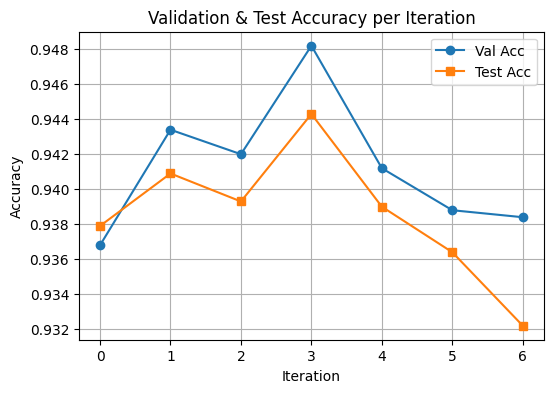

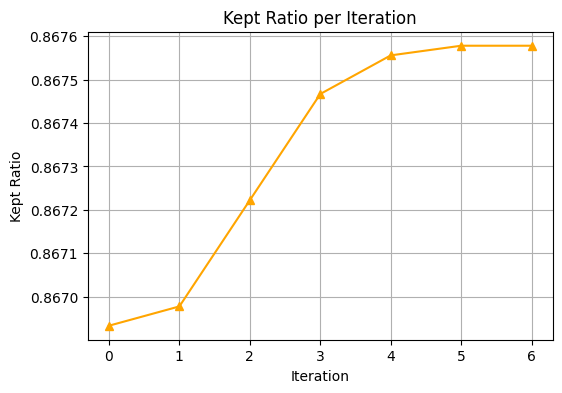

In [11]:
import matplotlib.pyplot as plt

# Vẽ acc theo iteration
plt.figure(figsize=(6,4))
plt.plot(summary_df["iteration"], summary_df["val_acc"], marker="o", label="Val Acc")
plt.plot(summary_df["iteration"], summary_df["test_acc"], marker="s", label="Test Acc")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Validation & Test Accuracy per Iteration")
plt.legend()
plt.grid(True)
plt.show()

# Vẽ kept ratio
plt.figure(figsize=(6,4))
plt.plot(summary_df["iteration"], summary_df["kept_ratio"], marker="^", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Kept Ratio")
plt.title("Kept Ratio per Iteration")
plt.grid(True)
plt.show()


# 8) How to resume
